# <p><center style="font-family:newtimeroman;font-size:180%;">Alzheimers  ADNI Detection </center></p>
### Table of contents:

* [Import Libraries](#1)
* [Read Data](#2)
* [Visualization Of Dataset](#3)
* [Data Augmentation](#4)
* [VGG16 Model](#10)
* [Evaluate The Model](#11)


**<a id="1"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">Import Libraries </p>
<a class="btn" href="#home">Tabel of Contents</a>

In [20]:
import os 
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
import keras 
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm
from imblearn.over_sampling import SMOTE

**<a id="2"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">Read Data </p>
<a class="btn" href="#home">Tabel of Contents</a>

In [21]:
images = []
labels = []
for subfolder in tqdm(os.listdir('/kaggle/input/kmeans-nonsegm')):
    subfolder_path = os.path.join('/kaggle/input/kmeans-nonsegm', subfolder)
    for folder in os.listdir(subfolder_path):
        # subfolder_path2=os.path.join(subfolder_path,folder)
        # for image_filename in os.listdir(subfolder_path2):
        image_path = os.path.join(subfolder_path, folder)
        images.append(image_path)
        labels.append(subfolder)
df = pd.DataFrame({'image': images, 'label': labels})
df

100%|██████████| 3/3 [00:00<00:00, 74.86it/s]


image label
0      /kaggle/input/kmeans-nonsegm/MCI/I20004_slice_...   MCI
1      /kaggle/input/kmeans-nonsegm/MCI/I46884_slice_...   MCI
2      /kaggle/input/kmeans-nonsegm/MCI/I137797_slice...   MCI
3      /kaggle/input/kmeans-nonsegm/MCI/I263034_slice...   MCI
4      /kaggle/input/kmeans-nonsegm/MCI/I56913_slice_...   MCI
...                                                  ...   ...
15326  /kaggle/input/kmeans-nonsegm/CN/I399701_slice_...    CN
15327  /kaggle/input/kmeans-nonsegm/CN/I476648_slice_...    CN
15328  /kaggle/input/kmeans-nonsegm/CN/I157178_slice_...    CN
15329  /kaggle/input/kmeans-nonsegm/CN/I71098_slice_0...    CN
15330  /kaggle/input/kmeans-nonsegm/CN/I23680_slice_5...    CN

[15331 rows x 2 columns]

In [3]:
df1=df[(df['label']=='AD') | (df['label']=='MCI') ]
df = df1

In [5]:
import pandas as pd


print(df['label'].value_counts())

# Trouver la taille de la plus petite classe
min_class_size = df['label'].value_counts().min()

# Échantillonner chaque classe pour obtenir le même nombre d'images
df_balanced = df.groupby('label').apply(lambda x: x.sample(min_class_size)).reset_index(drop=True)

# Afficher la distribution finale des étiquettes
print(df_balanced['label'].value_counts())


label
CN     5076
MCI    5023
Name: count, dtype: int64
label
CN     5023
MCI    5023
Name: count, dtype: int64


/tmp/ipykernel_35/2449948185.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('label').apply(lambda x: x.sample(min_class_size)).reset_index(drop=True)


In [8]:
df=df_balanced

**<a id="3"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">Visualization of Dataset </p>
<a class="btn" href="#home">Tabel of Contents</a>

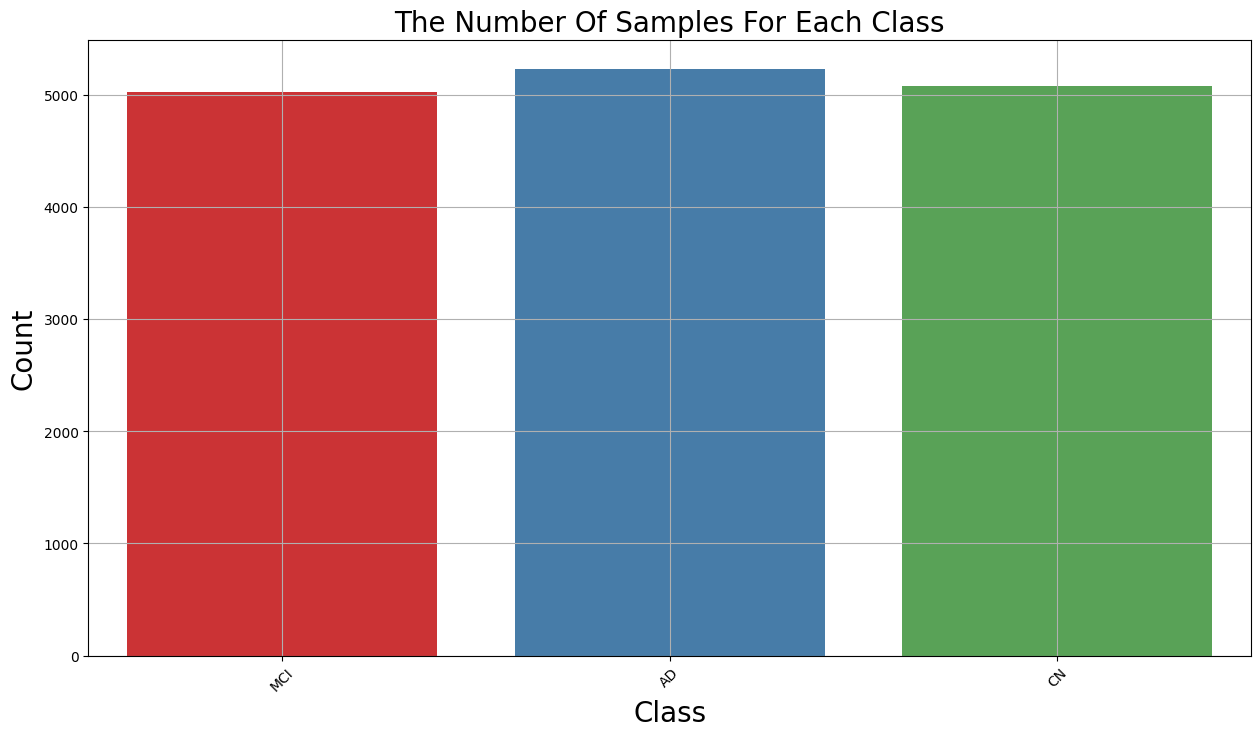

In [22]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x=df.label,palette='Set1')
ax.set_xlabel("Class",fontsize=20)
ax.set_ylabel("Count",fontsize=20)
plt.title('The Number Of Samples For Each Class',fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

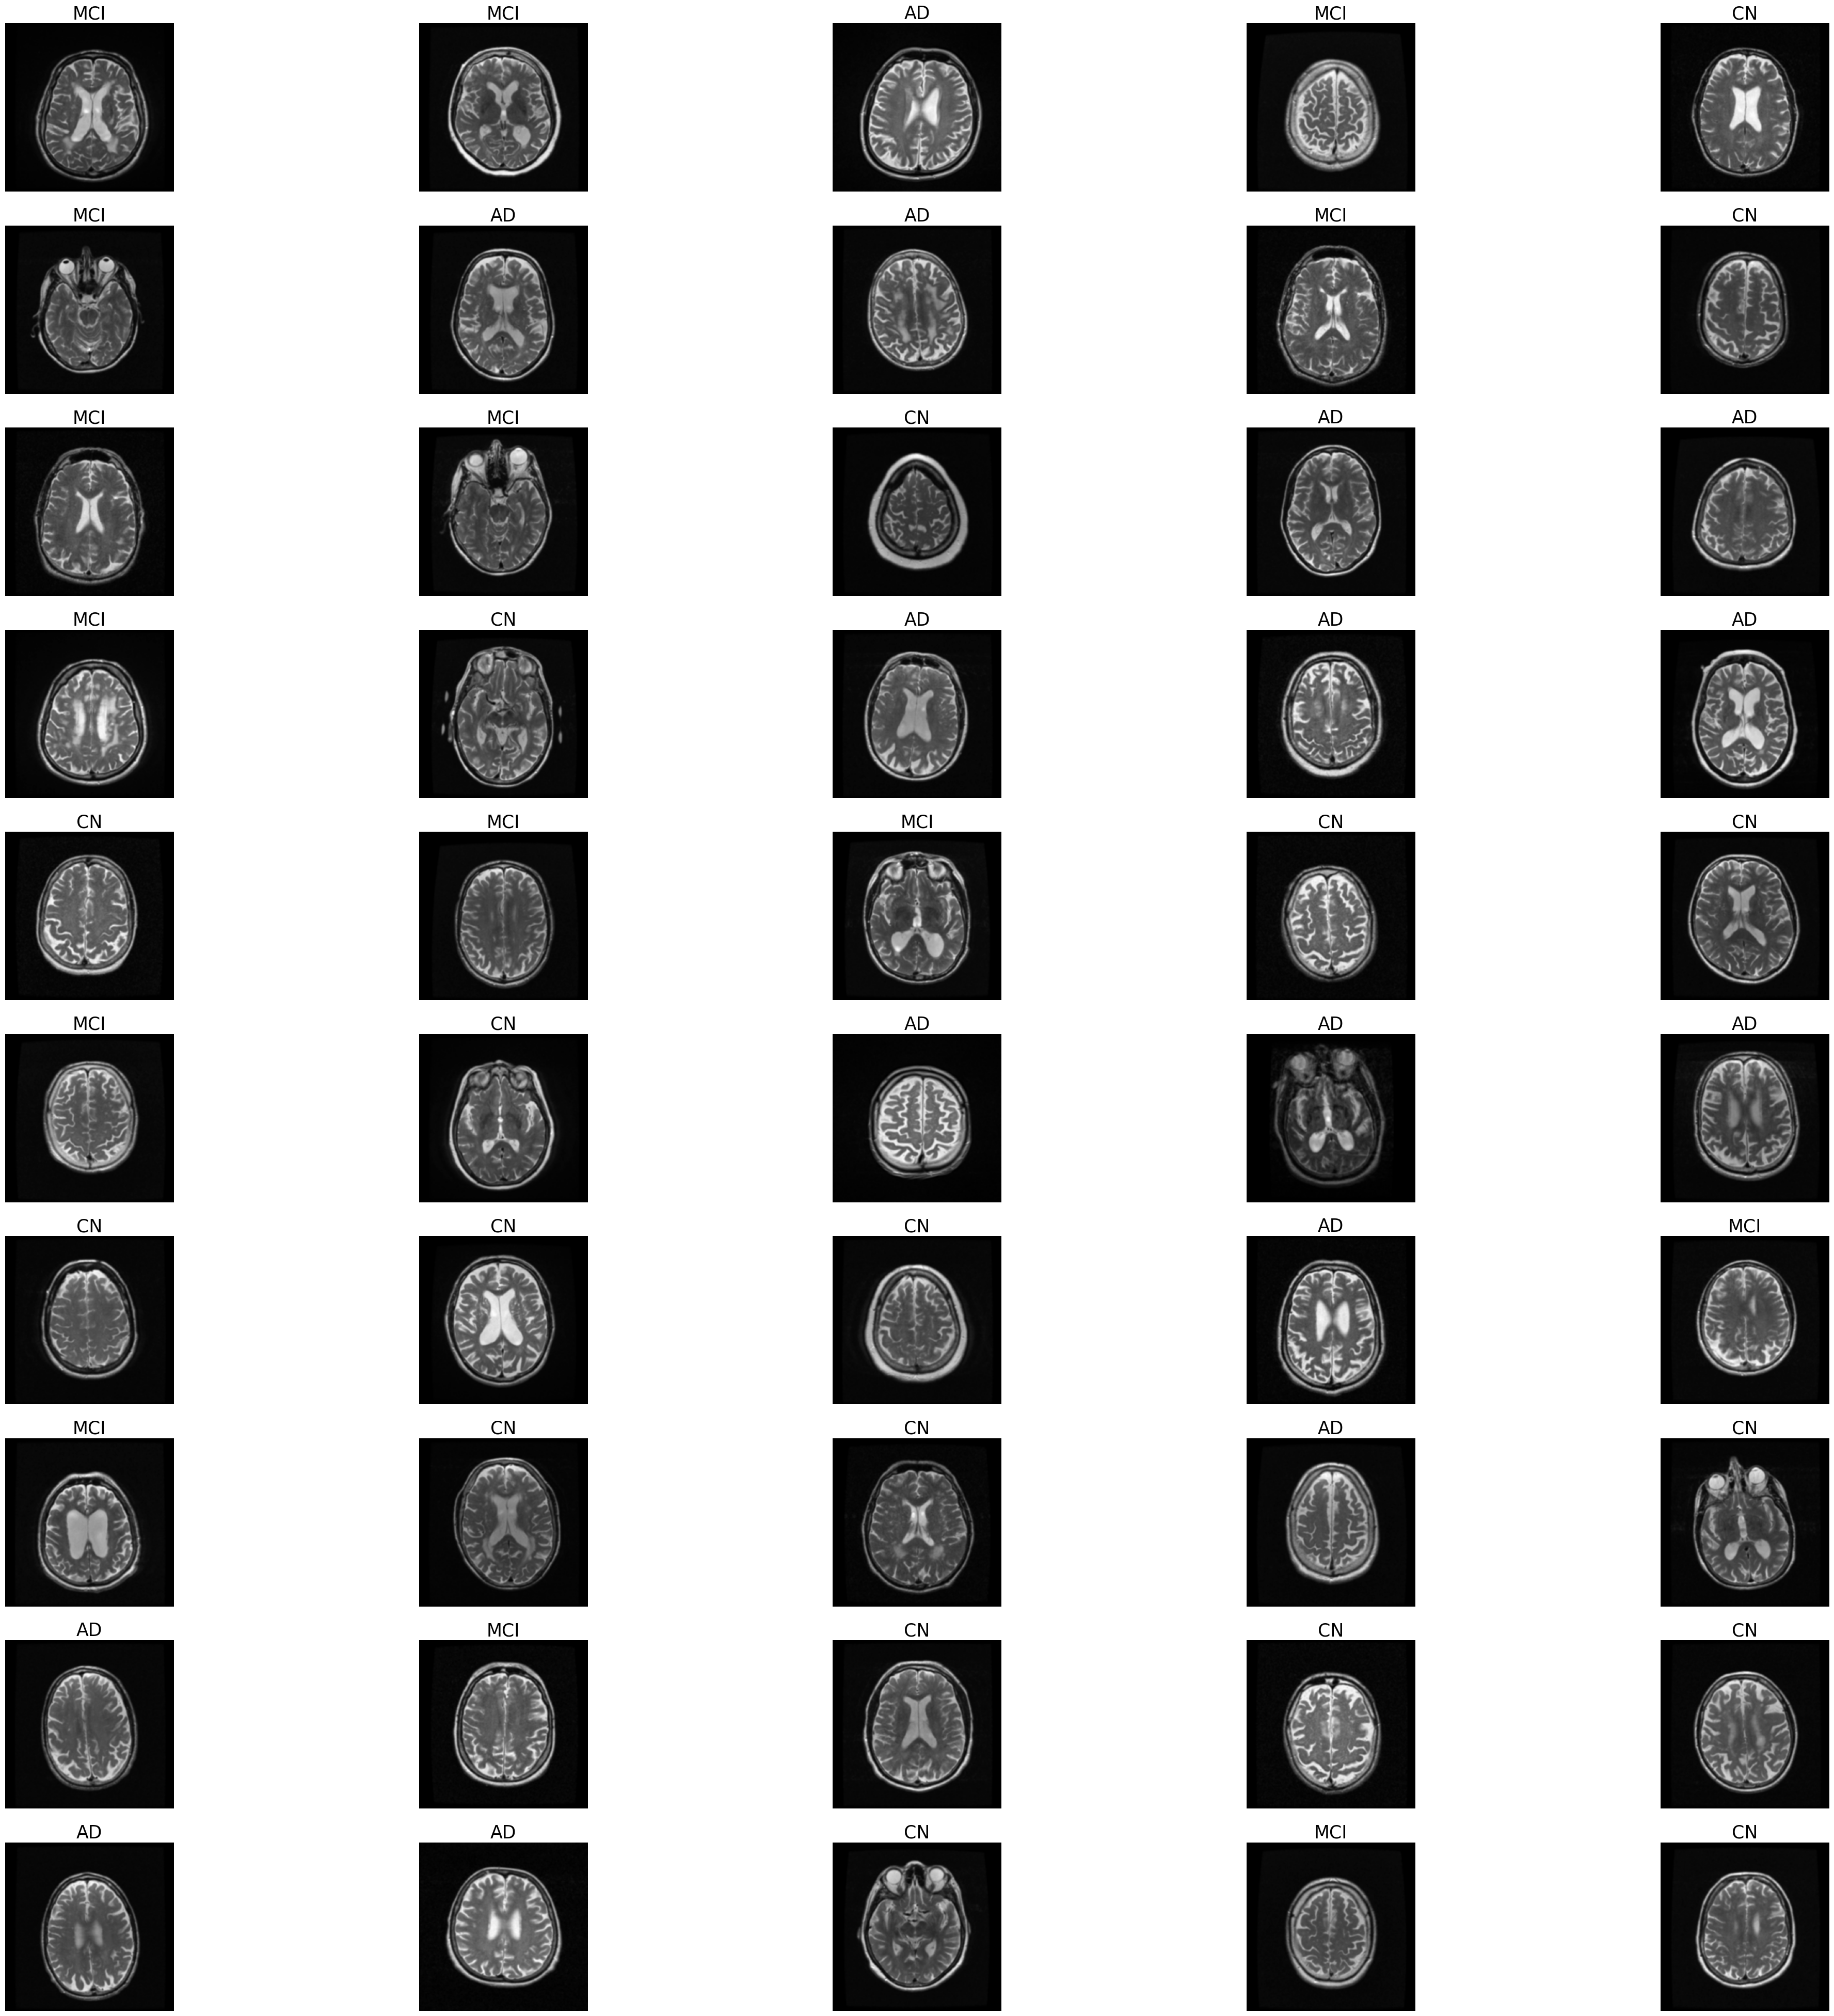

In [4]:
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(df),50)):
    plt.subplot(10,5,n+1)
    img=cv2.imread(df.image[i])
    img=cv2.resize(img,(224,224))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(df.label[i],fontsize=25)

<a id="4"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px"> Data Augmentation </p>
<a class="btn" href="#home">Tabel of Contents</a>

In [23]:
X_train, X_test1, y_train, y_test1 = train_test_split(df['image'], df['label'], test_size=0.2, random_state=42,shuffle=True,stratify=df['label'])
X_val, X_test, y_val, y_test = train_test_split(X_test1,y_test1, test_size=0.5, random_state=42,shuffle=True,stratify=y_test1)
df_train = pd.DataFrame({'image': X_train, 'label': y_train})
df_test = pd.DataFrame({'image': X_test, 'label': y_test})
df_val = pd.DataFrame({'image': X_val, 'label': y_val})

In [24]:
image_size = (224,224)
batch_size = 32
datagen = ImageDataGenerator(
    preprocessing_function= tf.keras.applications.resnet.preprocess_input,
#     rescale=1./255
#     horizontal_flip=True,
#     rotation_range=10,        # Utiliser une petite plage de rotation
#     width_shift_range=0.1,    # Décalage horizontal modéré
#     height_shift_range=0.1,   # Décalage vertical modéré
#     # shear_range=0.1,          # Cisaillement modéré
#     zoom_range=0.1,           # Zoom modéré
#     # brightness_range=[0.8, 1.2], # Variation de luminosité
#     fill_mode='nearest'       # Méthode de remplissage des pixels générés
)
train_generator = datagen.flow_from_dataframe(
    df_train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)
test_generator = datagen.flow_from_dataframe(
    df_test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
val_generator = datagen.flow_from_dataframe(
    df_val,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 12264 validated image filenames belonging to 3 classes.
Found 1534 validated image filenames belonging to 3 classes.
Found 1533 validated image filenames belonging to 3 classes.


In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = (224, 224)
batch_size = 32

# Création du générateur de données sans prétraitement complexe
datagen = ImageDataGenerator(
    rescale=1./255  # Normalisation des valeurs des pixels entre 0 et 1
)

# Générateur pour l'entraînement
train_generator = datagen.flow_from_dataframe(
    df_train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Générateur pour le test
test_generator = datagen.flow_from_dataframe(
    df_test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Générateur pour la validation
val_generator = datagen.flow_from_dataframe(
    df_val,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)


Found 8121 validated image filenames belonging to 2 classes.
Found 1016 validated image filenames belonging to 2 classes.
Found 1015 validated image filenames belonging to 2 classes.


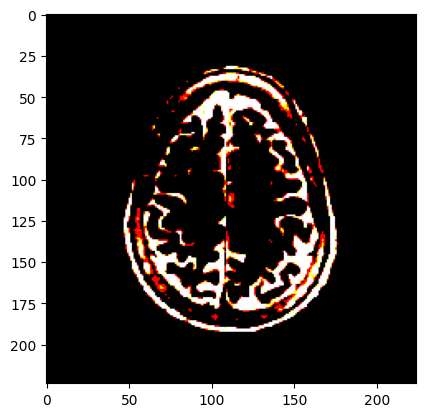

In [7]:
import matplotlib.pyplot as plt

# Obtenir une image du générateur
sample_image, _ = next(train_generator)

# Afficher l'image
plt.imshow(sample_image[5])
plt.show()


In [25]:
class_num=list(train_generator.class_indices.keys())
class_num

['AD', 'CN', 'MCI']

In [ ]:
from tensorflow.keras import layers, models

# Initialiser le modèle séquentiel
model = models.Sequential()

# Convolution Layer 1
model.add(layers.Conv2D(32, (4, 4), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.Dropout(0.2))
model.add(layers.ZeroPadding2D(padding=(3, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# Convolution Layer 2
model.add(layers.Conv2D(64, (5, 5), activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.ZeroPadding2D(padding=(2, 2)))
model.add(layers.MaxPooling2D((2, 2)))

# Convolution Layer 3
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.ZeroPadding2D(padding=(1, 1)))
model.add(layers.MaxPooling2D((2, 2)))

# Convolution Layer 4
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.ZeroPadding2D(padding=(1, 1)))
model.add(layers.MaxPooling2D((2, 2)))

# Convolution Layer 5
model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.ZeroPadding2D(padding=(1, 1)))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten pour passer aux couches entièrement connectées
model.add(layers.Flatten())

# Fully Connected Layers
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))

# Ajouter la couche de sortie pour la classification (par exemple, softmax pour 3 classes)
model.add(layers.Dense(2, activation='softmax'))

# Compiler le modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Afficher le résumé du modèle
model.summary()


In [ ]:
checkpoint_cb =ModelCheckpoint("model_VGG16.h5", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=15, restore_best_weights=True)
# model.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(train_generator, epochs=200, validation_data=val_generator, callbacks=[checkpoint_cb, early_stopping_cb])

<a id="10"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">VGG16 Modeling </p>
<a class="btn" href="#home">Tabel of Contents</a>

In [26]:
model = keras.models.Sequential()
model.add(tf.keras.applications.VGG16(input_shape=(224, 224, 3), include_top=False, pooling='avg', weights='imagenet'))
model.add(keras.layers.Flatten())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(2048, activation='relu'))
# model.add(keras.layers.Dropout(0.5))  # Ajout de dropout après la première couche dense
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(1024, activation='relu'))
# model.add(keras.layers.Dropout(0.5))  # Ajout de dropout après la deuxième couche dense
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(3, activation='softmax'))
model.layers[0].trainable = False
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 batch_normalization_6 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dense_6 (Dense)             (None, 2048)              1050624   
                                                                 
 batch_normalization_7 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense_7 (Dense)             (None, 1024)             

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, BatchNormalization, Dense, Input
from tensorflow.keras.models import Model

# Charger le modèle VGG16 avec les poids pré-entraînés d'ImageNet
base_model = VGG16(input_shape=(224, 224, 3), include_top=False, pooling='avg', weights='imagenet')

# Créez un modèle fonctionnel
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)  # Assurez-vous que base_model ne soit pas en mode entraînement
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(2048, activation='relu')(x)
# x = Dropout(0.5)(x)  # Ajouter Dropout si nécessaire
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
# x = Dropout(0.5)(x)  # Ajouter Dropout si nécessaire
outputs = Dense(3, activation='softmax')(x)

model = Model(inputs, outputs)

# Geler les poids du modèle VGG16 pré-entrainé
base_model.trainable = False

model.summary()


In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Checkpoint pour sauvegarder les meilleurs poids
checkpoint_cb = ModelCheckpoint("model_VGG16.h5", save_best_only=True)

# Early stopping pour éviter le surapprentissage
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)

# Scheduler pour réduire le taux d'apprentissage en cas de stagnation
reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Compiler le modèle avec l'optimiseur Adam
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entraînement du modèle avec les callbacks ajustés
hist = model.fit(train_generator, epochs=200, validation_data=val_generator, callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr_cb])


In [ ]:
from tensorflow.keras.optimizers import SGD
# Using SGD optimizer with lower learning rate and momentum
optimizer = SGD(learning_rate=0.001, momentum=0.9)

checkpoint_cb = ModelCheckpoint("model_VGG16.h5", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=15, restore_best_weights=True)  # Increase patience

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model
hist = model.fit(train_generator, epochs=200, validation_data=val_generator, callbacks=[checkpoint_cb, early_stopping_cb])

In [27]:
checkpoint_cb =ModelCheckpoint("model_VGG16.h5", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=15, restore_best_weights=True)
model.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(train_generator, epochs=200, validation_data=val_generator, callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/200
384/384 [==============================] - ETA: 0s - loss: 0.9298 - accuracy: 0.6578

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


384/384 [==============================] - 58s 144ms/step - loss: 0.9298 - accuracy: 0.6578 - val_loss: 0.7261 - val_accuracy: 0.7345
Epoch 2/200
384/384 [==============================] - 56s 146ms/step - loss: 0.5283 - accuracy: 0.7948 - val_loss: 0.5163 - val_accuracy: 0.8050
Epoch 3/200
384/384 [==============================] - 56s 145ms/step - loss: 0.3833 - accuracy: 0.8531 - val_loss: 0.4678 - val_accuracy: 0.8428
Epoch 4/200
384/384 [==============================] - 56s 146ms/step - loss: 0.2875 - accuracy: 0.8912 - val_loss: 0.3806 - val_accuracy: 0.8708
Epoch 5/200
384/384 [==============================] - 56s 146ms/step - loss: 0.2276 - accuracy: 0.9146 - val_loss: 0.3487 - val_accuracy: 0.8702
Epoch 6/200
384/384 [==============================] - 56s 146ms/step - loss: 0.1559 - accuracy: 0.9429 - val_loss: 0.3559 - val_accuracy: 0.8787
Epoch 8/200
384/384 [==============================] - 56s 145ms/step - loss: 0.1390 - accuracy: 0.9499 - val_loss: 0.3834 - val_accurac

<a id="11"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px"> Evaluate The Model  </p>
<a class="btn" href="#home">Tabel of Contents</a>

In [28]:
model.save('/kaggle/working/modele_checkpoint.h5')
print("Le modèle a été sauvegardé sous le nom 'mon_modele.h5'")

Le modèle a été sauvegardé sous le nom 'mon_modele.h5'


In [29]:
hist_=pd.DataFrame(hist.history)
hist_

loss  accuracy  val_loss  val_accuracy
0   0.929763  0.657779  0.726091      0.734508
1   0.528292  0.794765  0.516268      0.804958
2   0.383264  0.853066  0.467832      0.842792
3   0.287538  0.891226  0.380597      0.870842
4   0.227632  0.914628  0.348660      0.870189
5   0.184842  0.932078  0.349413      0.881931
6   0.155859  0.942922  0.355891      0.878669
7   0.139010  0.949935  0.383358      0.894325
8   0.123987  0.953115  0.373753      0.885845
9   0.130065  0.951402  0.334915      0.898239
10  0.090790  0.967629  0.379033      0.900196
11  0.106768  0.960779  0.311693      0.906719
12  0.083746  0.969912  0.344777      0.906067
13  0.083767  0.968037  0.333105      0.911937
14  0.083623  0.970809  0.319991      0.909980
15  0.089795  0.968363  0.255391      0.928245
16  0.066022  0.976190  0.283002      0.926288
17  0.054254  0.980675  0.400965      0.906719
18  0.071311  0.975294  0.315797      0.920417
19  0.061987  0.978066  0.297024      0.921070
20  0.066203  0.976354  0.292947      0.916504
21  0.063454  0.978474  0.294968      0.928898
22  0.061941  0.978229  0.264541      0.934768
23  0.055726  0.979860  0.516176      0.892368
24  0.060895  0.979126  0.335937      0.923679
25  0.041577  0.984181  0.314145      0.926288
26  0.048595  0.982551  0.269643      0.928245
27  0.049383  0.984181  0.312991      0.921070
28  0.044995  0.984344  0.296356      0.923679
29  0.050546  0.983040  0.379079      0.915851
30  0.046806  0.983203  0.297564      0.930202

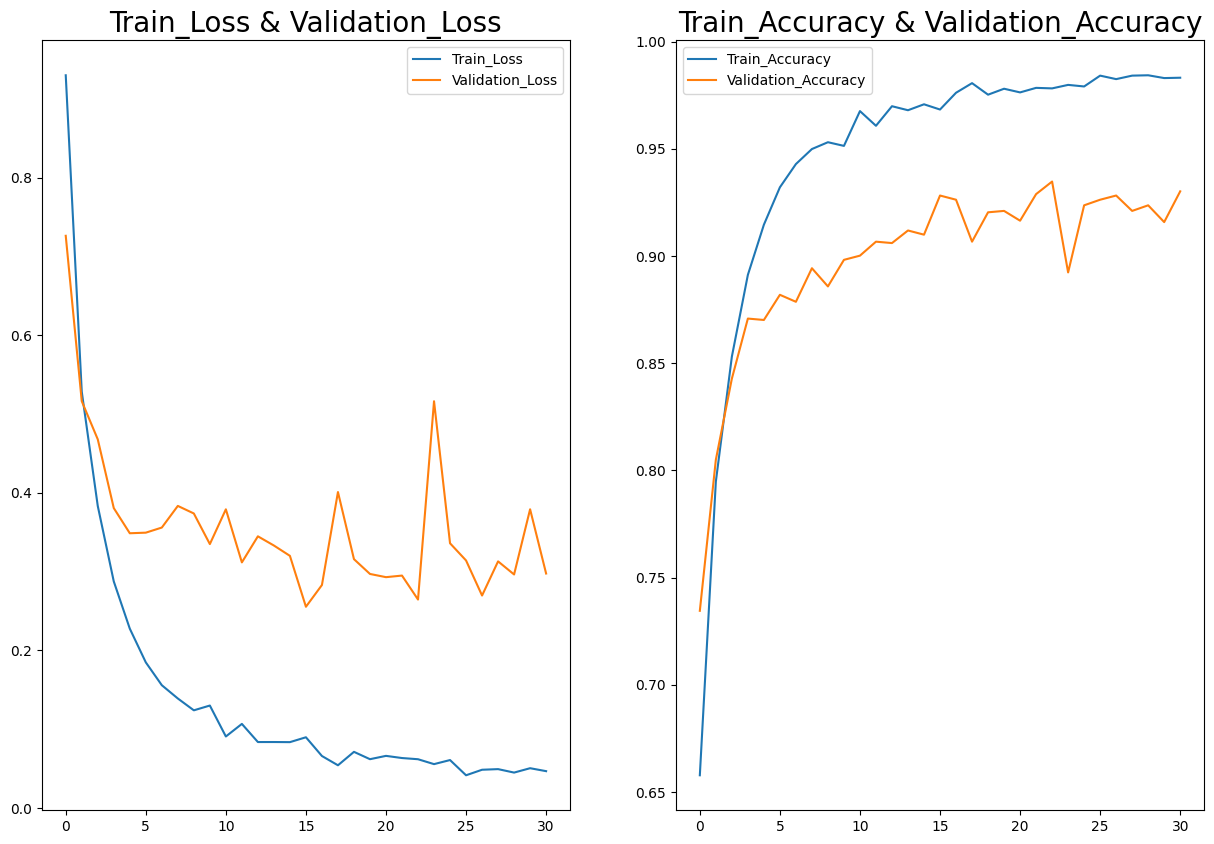

In [30]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.show()

In [31]:
score, acc= model.evaluate(test_generator)
print('Test Loss =', score)
print('Test Accuracy =', acc)

48/48 [==============================] - 22s 462ms/step - loss: 0.2770 - accuracy: 0.9146
Test Loss = 0.2770213484764099
Test Accuracy = 0.9146023392677307


In [32]:
y_test =test_generator.classes
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions,axis=1)
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)
df = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})
df

48/48 [==============================] - 6s 127ms/step


Actual  Prediction
0          2           2
1          0           1
2          2           2
3          2           2
4          1           1
...      ...         ...
1529       0           0
1530       1           1
1531       1           1
1532       0           0
1533       1           1

[1534 rows x 2 columns]

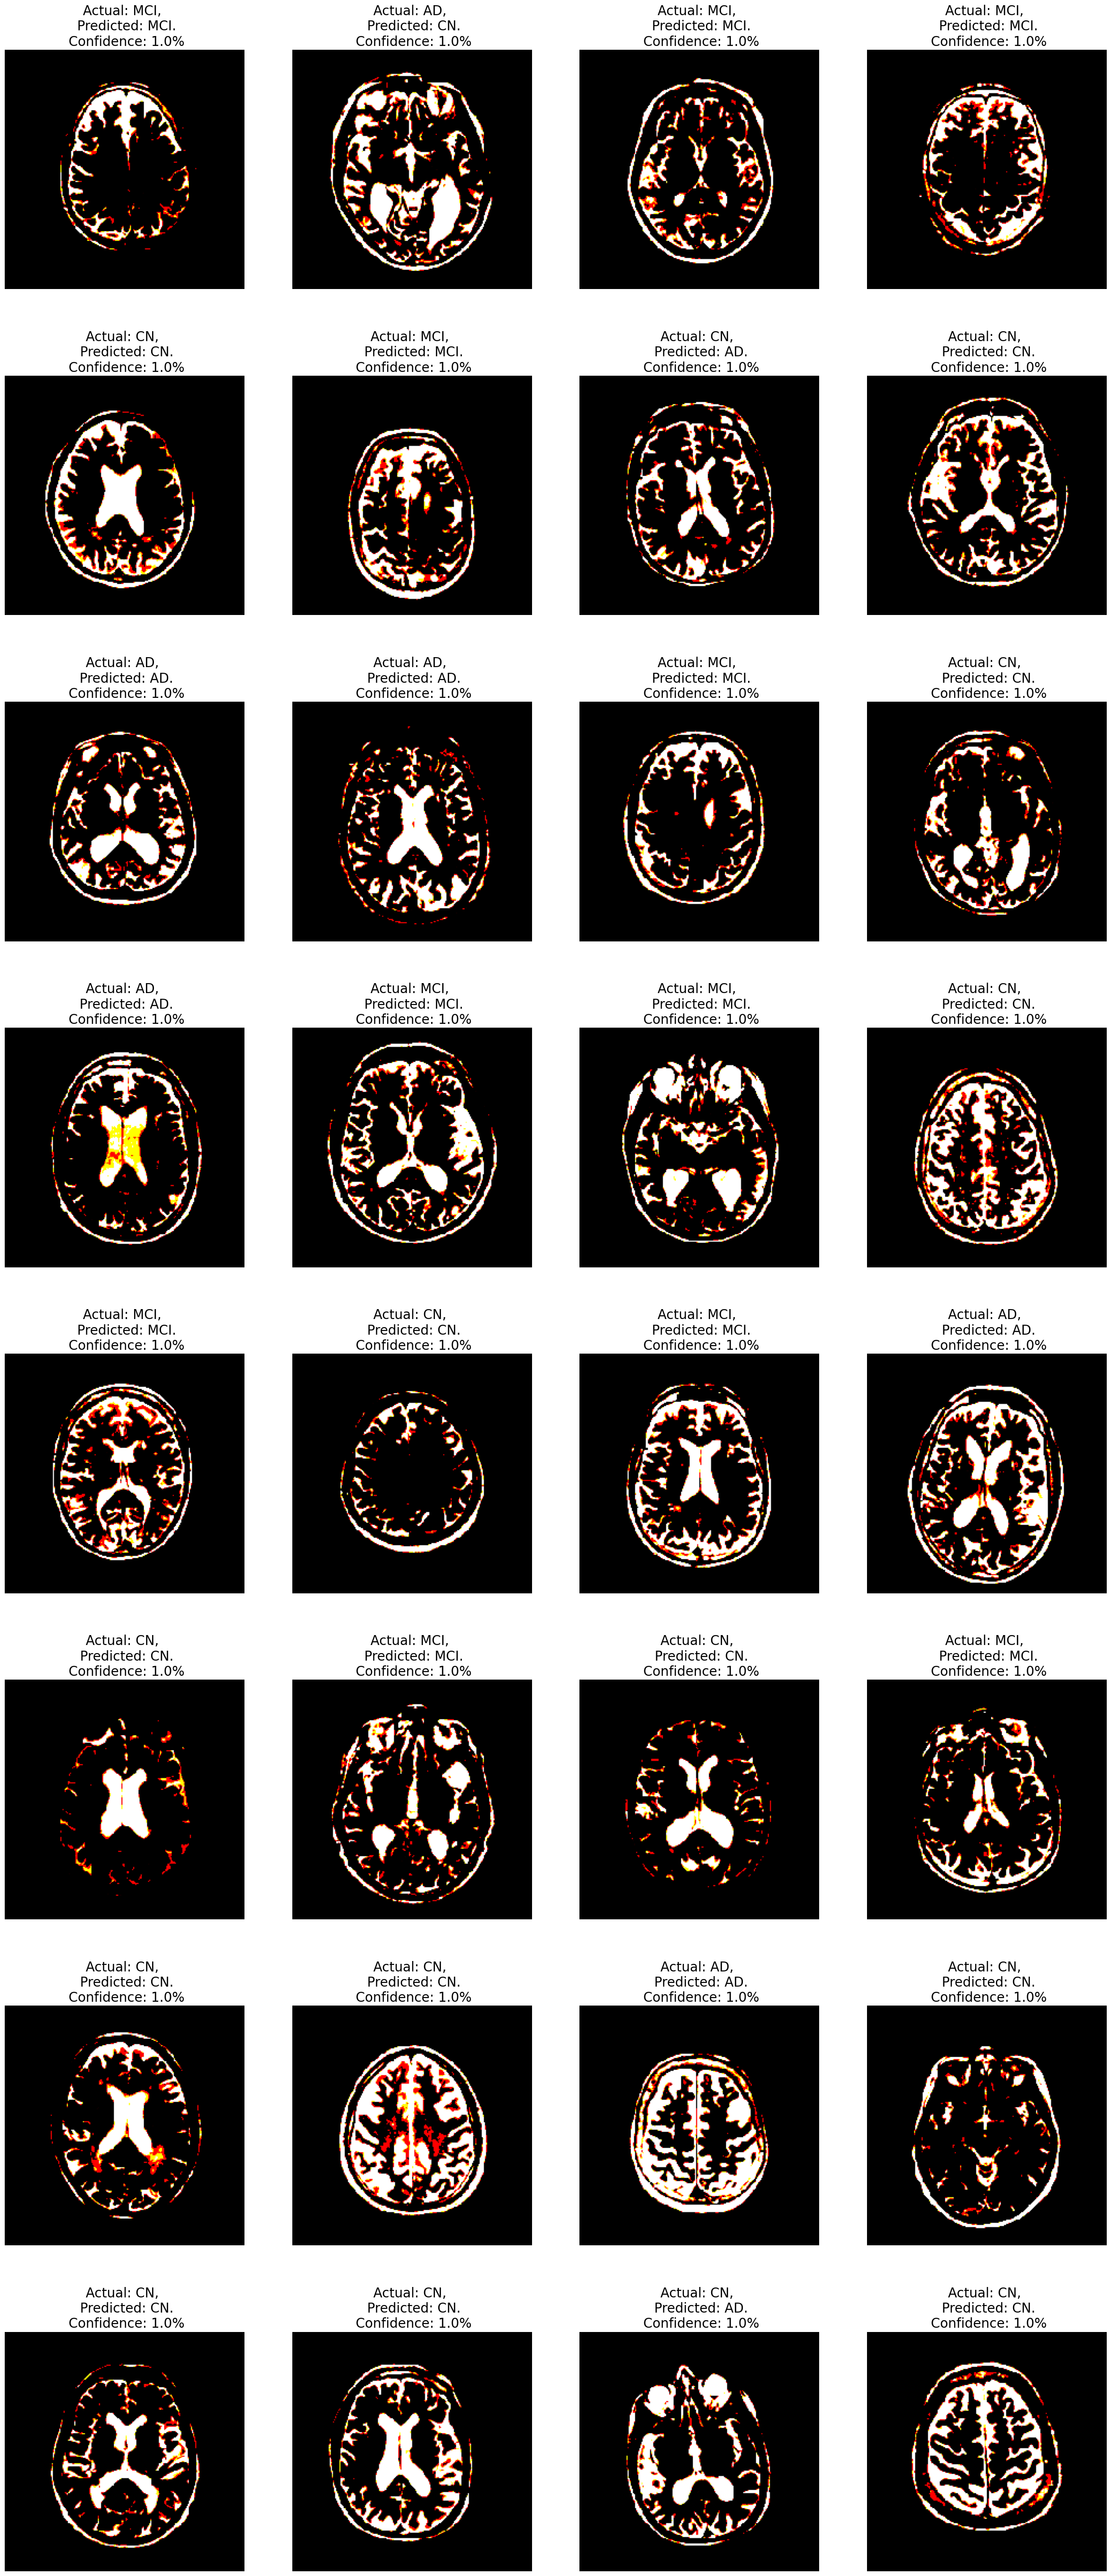

In [33]:
plt.figure(figsize=(30,70))
batch = next(test_generator)
images= batch[0]
for n in range(32):
    plt.subplot(8,4,n+1)
    plt.imshow(images[n])
    plt.axis('off')
    plt.title(f"Actual: {class_num[y_test[n]]}, \n Predicted: {class_num[y_pred[n]]}.\n Confidence: {round(predictions[n][np.argmax(predictions[n])],0)}%",fontsize=20)

array([[473,  16,  35],
       [ 20, 465,  23],
       [ 20,  17, 465]])

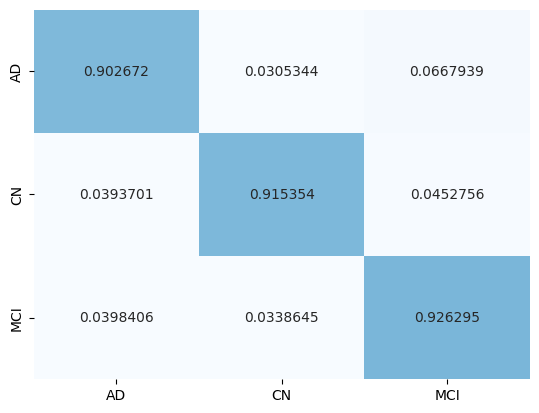

In [34]:
CM = confusion_matrix(y_test,y_pred)
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent,fmt='g',center = True,cbar=False,annot=True,cmap='Blues',xticklabels=class_num, yticklabels=class_num)
CM

In [35]:
ClassificationReport = classification_report(y_test,y_pred,target_names=class_num)
print('Classification Report is : ', ClassificationReport)

Classification Report is :                precision    recall  f1-score   support

          AD       0.92      0.90      0.91       524
          CN       0.93      0.92      0.92       508
         MCI       0.89      0.93      0.91       502

    accuracy                           0.91      1534
   macro avg       0.91      0.91      0.91      1534
weighted avg       0.92      0.91      0.91      1534

